In [1]:
from jupyter_imports import *
from copy import deepcopy

In [2]:
# run only once
from utils.MyLogger import ExecutionLogger # use 'prod' for remote after cache_tmp
start = datetime(2022,7,13,18)#,tzinfo=timezone.utc)
dirname = os.path.join(os.sep, 'tmp','prod','tradeexecutor')#,'prod')
ExecutionLogger.batch_summarize_exec_logs(dirname=dirname,start=start,add_history_context=False,rebuild=True)

'moved 1180 logs to unreadable'

In [4]:
files = ['all_by_clientOrderId','all_by_coin','all_by_symbol','all_parameters','all_inventory_manager','all_data','all_risk_recon']
original = {file:pd.read_csv(os.path.join(os.sep, dirname,f'{file}.csv'),parse_dates=['log_time'],index_col=0) for file in files}

In [5]:
cmap = cm.get_cmap('Spectral')
#fig, ax = plt.subplots(1)

## parameters for reference

In [7]:
all_parameters = original['all_parameters']
all_parameters['hash'] = all_parameters['log_time'].apply(lambda x: pd.util.hash_pandas_object(all_parameters.groupby('log_time').get_group(x).astype(str)).sum())
all_parameters['param_index'] = all_parameters['hash'].apply(lambda h: list(all_parameters['hash'].unique()).index(h))
all_parameters.drop(columns=['hash'],inplace=True)
param_map = all_parameters.set_index('log_time')['param_index'].to_dict()
param_map

{Timestamp('2022-07-24 13:08:03.629707+0000', tz='UTC'): 0,
 Timestamp('2022-07-24 11:15:53.736529+0000', tz='UTC'): 1,
 Timestamp('2022-07-24 13:23:21.912541+0000', tz='UTC'): 2,
 Timestamp('2022-07-23 22:07:57.535092+0000', tz='UTC'): 3,
 Timestamp('2022-07-24 16:04:43.307612+0000', tz='UTC'): 4,
 Timestamp('2022-07-24 10:29:26.257504+0000', tz='UTC'): 5,
 Timestamp('2022-07-24 14:21:40.558723+0000', tz='UTC'): 6,
 Timestamp('2022-07-24 12:16:24.755440+0000', tz='UTC'): 7,
 Timestamp('2022-07-24 16:29:40.632478+0000', tz='UTC'): 8,
 Timestamp('2022-07-24 09:40:18.640484+0000', tz='UTC'): 9,
 Timestamp('2022-07-24 15:19:05.414288+0000', tz='UTC'): 10,
 Timestamp('2022-07-24 16:49:11.451848+0000', tz='UTC'): 11,
 Timestamp('2022-07-24 15:13:50.638829+0000', tz='UTC'): 12,
 Timestamp('2022-07-24 12:58:38.930141+0000', tz='UTC'): 13,
 Timestamp('2022-07-24 11:34:29.598868+0000', tz='UTC'): 14,
 Timestamp('2022-07-24 11:27:33.514690+0000', tz='UTC'): 15,
 Timestamp('2022-07-24 14:02:03.01

In [8]:
indexed = deepcopy(original)
for df in indexed.values():
    df['param_index'] = df['log_time'].apply(lambda x:param_map[x])
#colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(all_parameters['param_index'].unique())))

### slippage, fees in bps. filled in USD

In [9]:
indexed['all_data'].columns

Index(['clientOrderId', 'eventID', 'state', 'remote_timestamp', 'timestamp',
       'id', 'symbol', 'type', 'side', 'amount', 'remaining', 'price',
       'comment', 'risk_timestamp', 'delta', 'netDelta', 'pv(wrong timestamp)',
       'margin_headroom', 'IM_discrepancy', 'mkt_timestamp', 'bid',
       'bidVolume', 'ask', 'askVolume', 'info', 'datetime',
       'lastTradeTimestamp', 'timeInForce', 'postOnly', 'reduceOnly',
       'stopPrice', 'cost', 'average', 'filled', 'status', 'fee', 'trades',
       'fees', 'orderTrigger', 'order', 'takerOrMaker', 'fillId', 'log_time',
       'param_index'],
      dtype='object')

In [10]:
by_symbol = indexed['all_by_symbol']
by_symbol = by_symbol[by_symbol['log_time']>start.replace(tzinfo=timezone.utc)]
by_symbol['absFilled'] = by_symbol['filledUSD'].apply(np.abs)
by_symbol['total_bps'] = by_symbol['slippage_bps'] + by_symbol['fee']
by_symbol['fee_USD'] = by_symbol['fee']*by_symbol['absFilled']/10000 # in bps for by_symbol, in USD for by_clientorderid :(
by_symbol['slippage_USD'] = by_symbol['slippage_bps']*by_symbol['absFilled']/10000
by_symbol['total_USD'] = by_symbol['total_bps']*by_symbol['absFilled']/10000

In [11]:
df_symbol = by_symbol[by_symbol['index']=='average'].pivot_table(index='log_time',aggfunc=sum)
df_symbol[['fee_USD','slippage_USD','total_USD']] /= 10000*by_symbol[by_symbol['index']=='average'].pivot_table(index='log_time',values=['absFilled'],aggfunc=sum).values

<AxesSubplot:xlabel='log_time'>

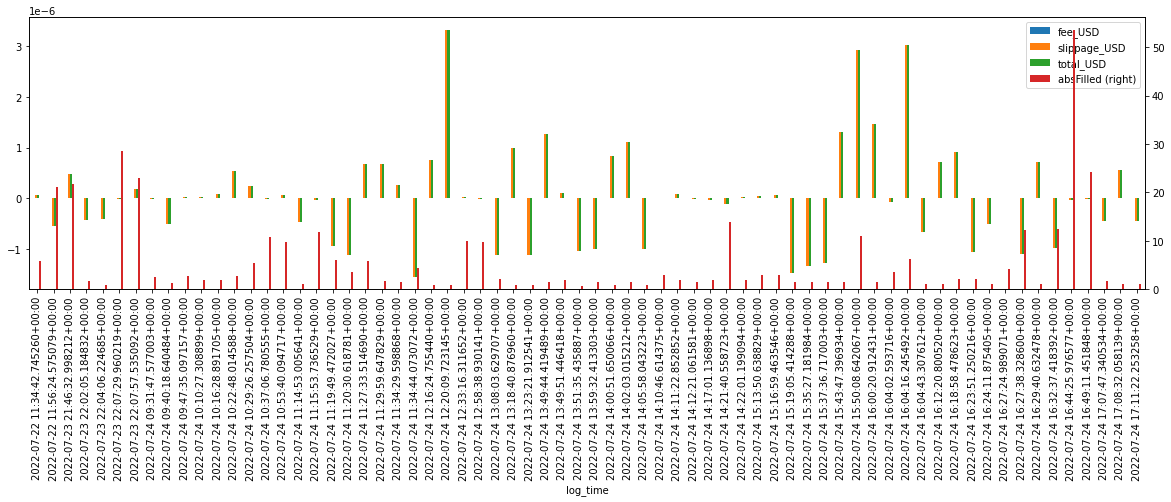

In [12]:
#ax.plot(df, c=df['param_index'], s=120, cmap=cmap, edgecolor='None',figsize=(20,10))
#plt.show()
df_symbol[['fee_USD','slippage_USD','total_USD','absFilled']].plot.bar(secondary_y='absFilled',figsize=(20,5))

### slippage distribution

        total_bps    fee
count  157.000000  157.0
mean     3.936020    0.0
std    102.221112    0.0
min   -217.521453    0.0
25%    -67.460317    0.0
50%     -0.694107    0.0
75%     67.220245    0.0
max    332.189126    0.0


<AxesSubplot:>

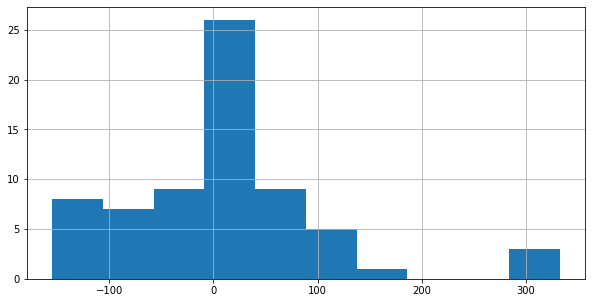

In [13]:
print(by_symbol[['total_bps','fee']].describe())
by_symbol.loc[by_symbol['index']=='average','total_bps'].hist(figsize=(10,5))

count     68.000000
mean       7.696484
std      192.988056
min     -309.315088
25%     -101.145114
50%       -0.763254
75%       98.790609
max      664.378253
Name: premium_vs_inception_bps, dtype: float64


<AxesSubplot:xlabel='log_time'>

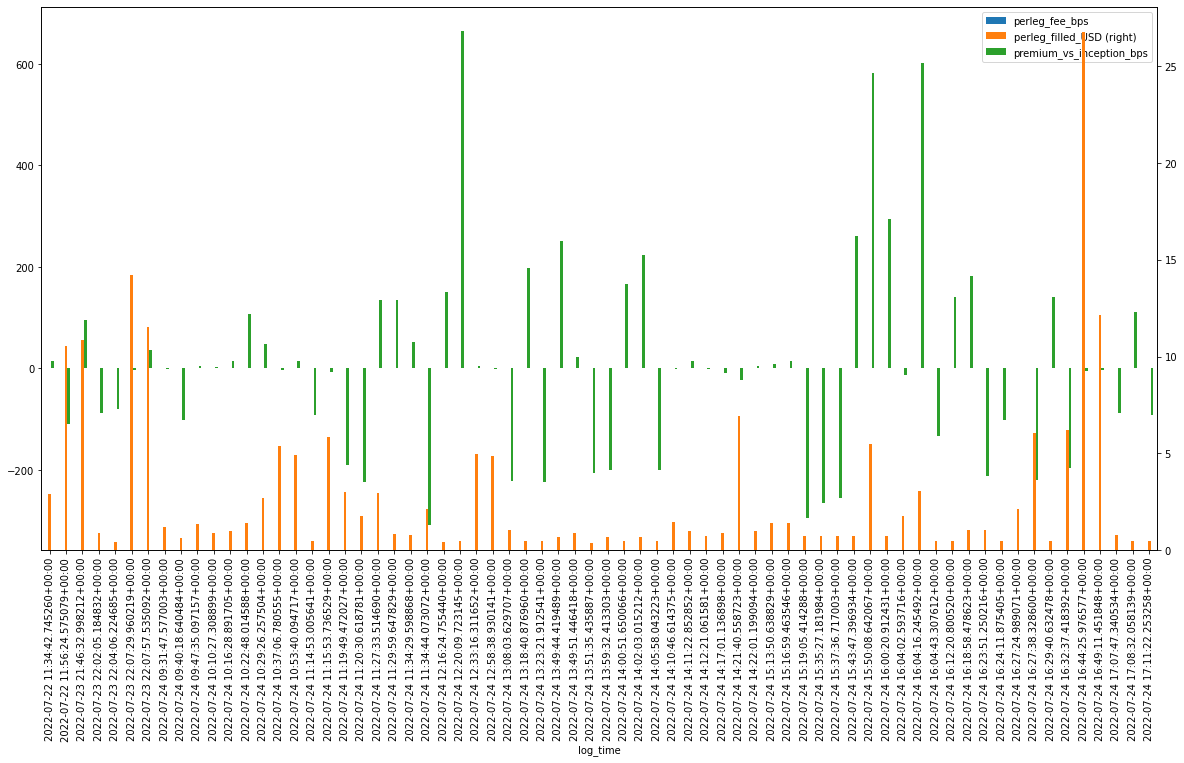

In [20]:
by_coin = indexed['all_by_coin']
trackrecord = by_coin[by_coin['index']=='average'].pivot_table(index='log_time',values=['perleg_fee_bps','perleg_filled_USD','premium_vs_inception_bps'],aggfunc=np.mean)
print(trackrecord['premium_vs_inception_bps'].describe())
trackrecord.plot.bar(secondary_y='perleg_filled_USD',figsize=(20,10))

# tick to ack

,pending_to_ack_local
count,95.000000
mean,137.335102
std,39.779530
min,91.300049
25%,110.906860
50%,126.967041
75%,152.607422
max,284.598877


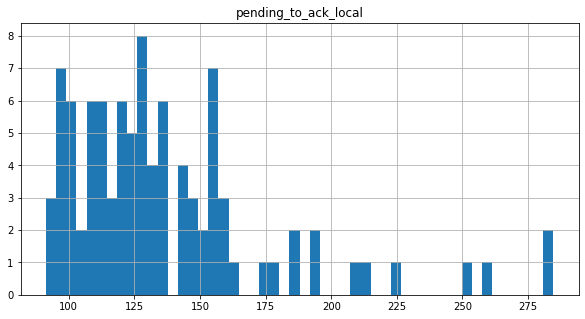

In [18]:
by_clientOrderId = indexed['all_by_clientOrderId']
tick_to_order_local = by_clientOrderId[['pending_to_ack_local']]
tick_to_order_local.hist(bins=50,figsize=(10,5))
tick_to_order_local.describe()

# remote vs local (~ round trip)

,round_trip
count,2077.000000
mean,65.754877
std,286.328392
min,0.011719
25%,0.040039
50%,31.991699
75%,69.883789
max,6425.367676


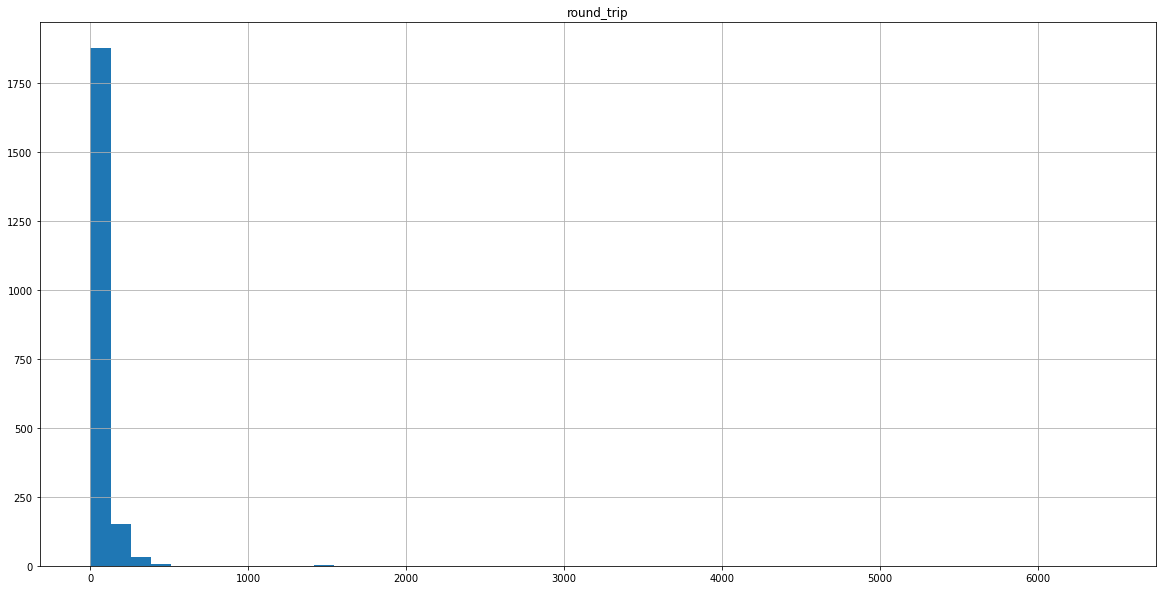

In [19]:
round_trip = pd.DataFrame(columns=['round_trip'], data = 2*(indexed['all_data']['timestamp']-indexed['all_data']['remote_timestamp']))
round_trip.hist(bins=50,figsize=(20,10))
round_trip.describe()